In [1]:
import re
import pandas as pd
import numpy as np
import os
import seaborn as sns
import h5py
import scipy.stats
import random
from matplotlib.pyplot import *
from statsmodels.nonparametric import smoothers_lowess
import statsmodels.stats.multitest
import sklearn
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import glob



sns.set_style("ticks")
%matplotlib inline

In [2]:
# define threshold for differentiation success/failure

threshold = 0.2

# specify output file for model score outputs

output_score_file = '/nfs/leia/research/stegle/dseaton/hipsci/singlecell_neuroseq/data/analysis_results/20200907_data_freeze/differentiation_trajectories/differentiation_efficiency_predictive_model_scores.tsv'
if not os.path.exists(os.path.dirname(output_score_file)):
    os.mkdir(os.path.dirname(output_score_file))

# Load data files

In [3]:
# load differentiation efficiency data and plot distribution, with the threshold shown

diff_file = '/nfs/leia/research/stegle/dseaton/hipsci/singlecell_neuroseq/data/data_processed/pool1_17_D52/pool1_17_D52.scanpy.w_metadata.w_celltype.scanpy.obs_df.groupedby.donor_id-pool_id-time_point.diff_efficiency_by_cell_line.tsv'

diff_df = pd.read_csv(diff_file, sep='\t', index_col=0)

diff_df.head()

,diff_efficiency
donor_id,
HPSI0114i-bezi_3,0.582697
HPSI0114i-eipl_1,0.012878
HPSI0114i-fikt_3,0.402827
HPSI0114i-kolf_2,0.470591
HPSI0114i-lexy_2,0.726905


(0, 45)

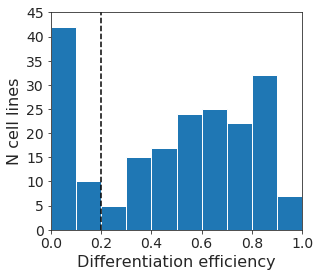

In [4]:
# plot differentiation efficiency distribution, showing threshold

FS = 16
ymax = 45

fig = figure(figsize=(4.5,4))

hist(diff_df['diff_efficiency'], bins=np.arange(0,1.01,0.1))
xlim([0,1])
yticks(fontsize=FS-2)
xticks(fontsize=FS-2)

xlabel('Differentiation efficiency', fontsize=FS)
ylabel('N cell lines', fontsize=FS)

plot([threshold, threshold],[0,ymax],'k--')
ylim([0,ymax])



In [5]:
# load bulk RNA-seq data

t_file = '/hps/nobackup/hipsci/scratch/trans_eqtls/IPS_Bulk-RNA_Processing/Merged/IPS_Bulk-RNA_Processing/FullFreeze_Corrected_iPSC_20180506.txt.gz'

# list of good iPSC RNA-seq samples, according to i2QTL
with open('/nfs/leia/research/stegle/dseaton/hipsci/singlecell_neuroseq/data/ipsc_deconvolution/I2QTL_HQ_sample_list.txt', 'r') as f:
    sample_list = [x.strip() for x in f.readlines()]

t_df = pd.read_csv(t_file, sep='\t', index_col=0)

t_df = t_df[sample_list]

# reformat HipSci IDs
t_df.columns = [x.replace('i.','i-').replace('.hs37d5','') for x in t_df.columns]
# restrict to HipSci samples
t_df = t_df.loc[:, [x.startswith('HPSI') for x in t_df.columns]]
# restrict to expressed genes
t_df = t_df[t_df.mean(axis=1)>2.0]
# restrict to ENSGs
t_df = t_df.loc[[x for x in t_df.index if x.startswith('ENSG')]]


# z-score
t_df = t_df.apply(lambda x: (x-x.mean())/x.std(), axis=1)

feature_list = list(t_df.index)
print(t_df.shape)

t_df.head()

(15139, 812)


,HPSI0114i-bezi_1,HPSI0114i-bezi_3,HPSI0114i-eipl_1,HPSI0114i-eipl_3,HPSI0114i-fikt_3,HPSI0114i-iisa_1,HPSI0114i-iisa_3,HPSI0114i-joxm_1,HPSI0114i-kolf_2,HPSI0114i-kolf_3,...,HPSI1213i-babk_2,HPSI1213i-foqj_2,HPSI1213i-hehd_1,HPSI1213i-hehd_2,HPSI1213i-nekd_1,HPSI1213i-pahc_4,HPSI1213i-pahc_5,HPSI1213i-tolg_4,HPSI1213i-tolg_6,HPSI1213i-xuja_2
ENSG00000227232,1.071811,0.685401,1.200764,1.480218,-0.618699,-0.473364,0.263403,1.199250,0.231465,1.932879,...,0.561991,1.287332,-0.051791,0.216203,0.690719,1.962538,0.619636,-0.619074,0.230659,1.918264
ENSG00000237683,-0.957136,-0.300074,0.433929,0.371810,-0.528963,-0.562059,-0.068356,0.319065,0.740055,0.307423,...,-0.525286,0.731635,-0.840911,0.102353,0.703138,0.762919,-0.612958,-0.656354,0.307759,0.092023
ENSG00000239906,-1.737807,-0.752634,-0.122477,0.263424,-1.126261,-0.397555,0.379548,-0.946729,-0.206013,0.089825,...,-0.892981,0.212391,-0.816380,0.047185,0.859884,0.932519,-0.274031,-0.578157,1.192706,-0.629570
ENSG00000241860,-0.600611,-0.555037,0.356860,0.204071,-0.470216,-0.804048,-0.517170,-0.053584,0.211130,0.330379,...,-0.738488,0.257059,-0.399398,0.155672,0.003583,0.199589,-0.987295,-0.402131,0.422672,-0.408624
ENSG00000237094,-0.498679,-0.385110,0.096240,-0.094836,-0.337741,-0.308685,0.017538,-0.014175,0.179577,0.320673,...,-0.278268,0.082851,-0.544142,-0.195672,-0.075347,0.510103,-0.052133,-0.171043,0.132724,0.136985


In [6]:
# merge data, and define diff success and failure with a threshold

df_temp = t_df.transpose()

all_data_df = diff_df.join(df_temp, how='inner').dropna()

all_data_df['diff_success'] = all_data_df['diff_efficiency'].apply(lambda x : int(x>threshold))
all_data_df['diff_failure'] = 1-all_data_df['diff_success']

print(all_data_df.shape)
all_data_df.head()

(184, 15142)


,diff_efficiency,ENSG00000227232,ENSG00000237683,ENSG00000239906,ENSG00000241860,ENSG00000237094,ENSG00000250575,ENSG00000225972,ENSG00000225630,ENSG00000237973,...,ENSG00000266219,ENSG00000272060,ENSG00000242716,ENSG00000266658,ENSG00000265830,ENSG00000215700,ENSG00000215699,ENSG00000215611,diff_success,diff_failure
HPSI0114i-bezi_3,0.582697,0.685401,-0.300074,-0.752634,-0.555037,-0.385110,-0.382939,0.119837,0.471207,0.410364,...,-1.613157,1.067181,0.484570,0.513481,-2.381168,0.075393,0.448618,-0.251404,1,0
HPSI0114i-eipl_1,0.012878,1.200764,0.433929,-0.122477,0.356860,0.096240,-0.588702,0.290450,0.392902,0.591551,...,-0.978252,1.051220,0.231354,0.624148,0.010544,-0.140491,0.016786,0.789268,0,1
HPSI0114i-fikt_3,0.402827,-0.618699,-0.528963,-1.126261,-0.470216,-0.337741,-0.490819,0.106740,0.283789,0.281315,...,-1.257670,0.297540,-0.313244,-0.367095,0.163823,0.458841,0.190299,0.676327,1,0
HPSI0114i-kolf_2,0.470591,0.231465,0.740055,-0.206013,0.211130,0.179577,0.334349,0.476299,0.632902,0.527476,...,-0.358525,0.493449,0.101426,0.160526,0.377162,0.086937,0.541999,-1.155729,1,0
HPSI0114i-lexy_2,0.726905,-0.416274,0.192617,-0.736757,-0.653100,-0.156936,-0.211170,0.594784,1.154969,0.550378,...,-2.191140,0.667061,0.116528,0.079265,-0.308972,0.559862,0.861976,-0.558578,1,0


# Train and evaluate model

In [7]:
# specify model and what measure of differntiation will be predicted
model = sklearn.linear_model.LogisticRegression(penalty='l1', C=1.0, random_state=0)

diff_measure = 'diff_failure'

In [8]:
### plot precision recall for leave-one-out cross validation

y_test_list = []
y_pred_list = []
r2_list = []
n_coeff_list = []
coeff_list = []
y_pred_prob_list = []

n_test = 1

df = all_data_df.copy()




samples = list(df.index)

for idx in range(len(samples))[:]:
    samples = samples[n_test:] + samples[:n_test]

    X = df.loc[samples, feature_list].values
    y = df.loc[samples, diff_measure].values

    # Split data in train set and test set
    n_samples = X.shape[0]
    n_train = n_samples - n_test
    X_train, y_train = X[:n_train], y[:n_train]
    X_test, y_test = X[n_train:], y[n_train:]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]

    y_test_list.extend(list(y_test))
    y_pred_list.extend(list(y_pred_prob))
    y_pred_prob_list.extend(list(y_pred_prob))



/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.35416667 0.33333333 0.3125     0.29166667 0.27083333 0.25
 0.22916667 0.20833333 0.1875     0.16666667 0.14583333 0.125
 0.10416667 0.08333333 0.0625     0.04166667 0.02083333 0.        ]
[0.97769    0.98304166 0.99196091 0.9962966  0.99749399 0.99771895
 0.99886654 0.99895311 0.99935197 0.99974031 0.99993765 0.9999653
 0.99997348 0.99998636 0.99999541 0.9999964  0.99999696 0.99999959]


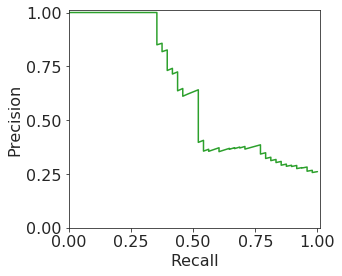

In [9]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_test_list, y_pred_prob_list)
fig = figure(figsize=(4.5,4))

plot(recall, precision, '-', color='#2ca02c')
xlabel('Recall', fontsize=16)
ylabel('Precision', fontsize=16)
xticks(np.arange(0,1.01,0.25), fontsize=16)
yticks([0,0.25,0.5,0.75,1.0], fontsize=16)
xlim([0,1.01])
ylim([0.0,1.01])

fig.savefig('./figures/predictive_model.leave_one_out_PR_curve.pdf', bbox_inches='tight')

# print recall levels for which precision is very high
print(recall[precision>0.99])
# print model scores for which precision is very high
print(thresholds[precision[:-1]>0.9])


In [10]:
selected_precision = 0.9

# convert threshold to a model score that the value needs to fall BELOW
# in order to be classed as a bad differentiator (sklearn considers precision-recall)
# of the class in the opposite direction).
inverted_thresholds = (1-thresholds)

# select the maximum threshold. Scores under this threshold imply precision at the specified level
# NB: precision is indexed to match the thresholds, but has one additional element, so must be truncated here
selected_threshold = max(inverted_thresholds[precision[:-1]>selected_precision])

# view recall levels at this precision level
print(recall[precision[:]>selected_precision])
print(selected_threshold)

[0.35416667 0.35416667 0.33333333 0.3125     0.29166667 0.27083333
 0.25       0.22916667 0.20833333 0.1875     0.16666667 0.14583333
 0.125      0.10416667 0.08333333 0.0625     0.04166667 0.02083333
 0.        ]
0.022310003415187296


# Train full model and output predictions and model


In [11]:
# train the model on all data
df = all_data_df.copy()
samples = list(df.index)
X_train = df.loc[samples, feature_list].values
y_train = df.loc[samples, diff_measure].values

model.fit(X_train, y_train)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

,donor_id,diff_efficiency,diff_outcome,model_score,model_predicted_outcome
0,HPSI0114i-bezi_1,NaN,not_assessed,0.795830,success
1,HPSI0114i-bezi_3,0.582697,success,0.990336,success
2,HPSI0114i-eipl_1,0.012878,failure,0.008453,failure
3,HPSI0114i-eipl_3,NaN,not_assessed,0.009314,failure
4,HPSI0114i-fikt_3,0.402827,success,0.950780,success


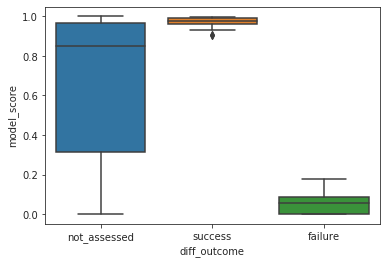

In [12]:
# extrapolate to all hipsci, including a column with the actual differentiation results for
# cell lines that were included in NeuroSeq

samples = t_df.columns
X_all = t_df.loc[feature_list, samples].transpose()

y_pred = model.predict(X_all)
y_pred_prob = model.predict_proba(X_all)[:,0]

score_df = pd.DataFrame({'donor_id':samples, 'model_score':y_pred_prob})
score_df = score_df.merge(diff_df, on='donor_id', how='left')

score_df['model_predicted_outcome'] = score_df['model_score'].apply(lambda x: 'success' if x>selected_threshold else 'failure')

def convert_eff_to_label(x):
    if np.isnan(x):
        return 'not_assessed'
    elif x < threshold:
        return 'failure'
    elif x >= threshold:
        return 'success'

score_df['diff_outcome'] = score_df['diff_efficiency'].apply(convert_eff_to_label)

sns.boxplot(data=score_df, x='diff_outcome', y='model_score')

score_df = score_df[['donor_id','diff_efficiency','diff_outcome','model_score','model_predicted_outcome']]

score_df.to_csv(output_score_file, sep='\t', index=False)

score_df.head()

In [13]:
output_score_file

'/nfs/leia/research/stegle/dseaton/hipsci/singlecell_neuroseq/data/analysis_results/20200907_data_freeze/differentiation_trajectories/differentiation_efficiency_predictive_model_scores.tsv'

In [14]:
score_df.shape

(812, 5)

(array([100.,  12.,  10.,  17.,  13.,  12.,   2.,   6.,   8.,   5.,   3.,
          5.,   2.,   4.,   3.,   5.,   2.,   6.,   4.,   5.,   3.,   4.,
          4.,   1.,   4.,   3.,   2.,   4.,   7.,   5.,   6.,   5.,   4.,
          4.,   9.,   6.,   9.,   9.,  13.,  11.,   9.,  13.,  11.,  14.,
         18.,  30.,  44.,  57., 107., 172.]),
 array([4.92674257e-07, 1.99996594e-02, 3.99988261e-02, 5.99979928e-02,
        7.99971595e-02, 9.99963262e-02, 1.19995493e-01, 1.39994660e-01,
        1.59993826e-01, 1.79992993e-01, 1.99992160e-01, 2.19991326e-01,
        2.39990493e-01, 2.59989660e-01, 2.79988826e-01, 2.99987993e-01,
        3.19987160e-01, 3.39986327e-01, 3.59985493e-01, 3.79984660e-01,
        3.99983827e-01, 4.19982993e-01, 4.39982160e-01, 4.59981327e-01,
        4.79980493e-01, 4.99979660e-01, 5.19978827e-01, 5.39977994e-01,
        5.59977160e-01, 5.79976327e-01, 5.99975494e-01, 6.19974660e-01,
        6.39973827e-01, 6.59972994e-01, 6.79972160e-01, 6.99971327e-01,
        7.

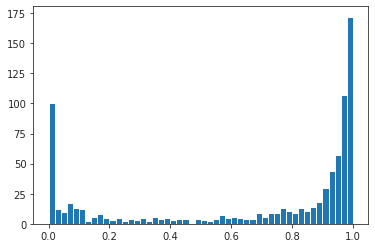

In [15]:
hist(score_df['model_score'], bins=50)

In [16]:
df = pd.DataFrame({'feature':feature_list, 'coefficient':model.coef_[0]})

df = df.query('coefficient!=0')

# swap the direction so that predictions are on the same scale as above
df['coefficient'] = -1.0*df['coefficient']

intercept_ds = pd.Series({'feature':'intercept', 'coefficient':model.intercept_[0]})

df = df.append(intercept_ds, ignore_index=True)


df.to_csv('./model_coefficients.tsv', sep='\t', index=False)



In [17]:
df

,feature,coefficient
0,ENSG00000182873,0.102205
1,ENSG00000233929,0.019059
2,ENSG00000235912,-0.135866
3,ENSG00000236624,0.146026
4,ENSG00000223416,0.314346
...,...,...
106,ENSG00000189306,-0.012645
107,ENSG00000205559,0.092713
108,ENSG00000243927,0.010925
109,ENSG00000220023,-0.484220


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/nfs/software/stegle/system/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


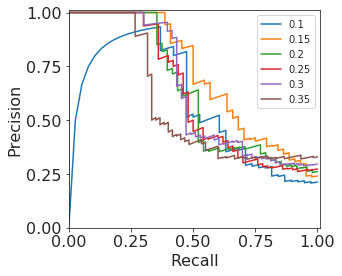

In [18]:
### plot precision recall for a range of thresholds

n_test = 1

fig = figure(figsize=(4.5,4))

threshold_list = [0.1,0.15,0.2,0.25,0.3,0.35]

aupr_list = []

for alternative_threshold in threshold_list:
    y_test_list = []
    y_pred_list = []
    r2_list = []
    n_coeff_list = []
    coeff_list = []
    y_pred_prob_list = []

    df = all_data_df.copy()
    df['diff_success'] = df['diff_efficiency'].apply(lambda x : int(x>alternative_threshold))
    df['diff_failure'] = 1-df['diff_success']

    diff_measure = 'diff_failure'
    samples = list(df.index)

    for idx in range(len(samples))[:]:

        samples = samples[n_test:] + samples[:n_test]

        X = df.loc[samples, feature_list].values
        y = df.loc[samples, diff_measure].values


        # Split data in train set and test set
        n_samples = X.shape[0]
        n_train = n_samples - n_test
        X_train, y_train = X[:n_train], y[:n_train]
        X_test, y_test = X[n_train:], y[n_train:]
        
        # same model as above
        #model = sklearn.linear_model.LogisticRegression(penalty='l1', C=1.0)
        model = model

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:,1]

        y_test_list.extend(list(y_test))
        y_pred_list.extend(list(y_pred_prob))
        y_pred_prob_list.extend(list(y_pred_prob))

    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_test_list, y_pred_prob_list)
    aupr_list.append(sklearn.metrics.auc(recall, precision))
    plot(recall, precision, '-')

xlabel('Recall', fontsize=16)
ylabel('Precision', fontsize=16)
xticks([0,0.25,0.5,0.75,1.0], fontsize=16)
yticks([0,0.25,0.5,0.75,1.0], fontsize=16)
xlim([0,1.01])
ylim([0.0,1.01])
legend([str(x) for x in threshold_list])

fig.savefig('./figures/predictive_model.PR_curves_across_thresholds.pdf', bbox_inches='tight')


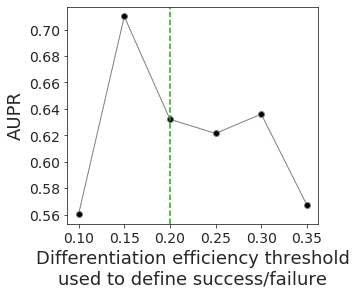

In [19]:
# plot aupr


fig = figure(figsize=(4.5,4))
plot(threshold_list, aupr_list, 'o-', linewidth=1, color='grey', markerfacecolor='black')
xlabel('Differentiation efficiency threshold\nused to define success/failure', fontsize=18)
ylabel('AUPR', fontsize=18)
axvline([0.20], color='#2ca02c', linestyle='--')
xticks(fontsize=14)
yticks(fontsize=14)

fig.savefig('./figures/predictive_model.AUPR_across_thresholds.pdf', bbox_inches='tight')

# ylim([0,0.8])
# plt.axhline(y=, color='r', linestyle='-')